***Adsorción de aguas grises con lecho fijo de carbón activado***

La siguiente ecuación modela la adsorción no estacionaria, despreciando la difusión como mecanismo de transferencia de masa y considerando la convección y acumulación del contaminante de interés tanto en el adsorbedor (W) como en la fase fluida (c) [1]:
\begin{equation}
\epsilon\frac{\partial c}{\partial t} + \rho_p (1 - \epsilon)\frac{\partial W}{\partial t}  = -u_o \frac{\partial c}{\partial z}
\end{equation}
Se usa la siguiente ecuación para establecer una relación entre la concentración de la fase fluida y el adsorbente:
$$\rho_p (1 - \epsilon)\frac{\partial W}{\partial t}  = K_c a (c - c^*)$$

Resulta la siguiente ecuación principal:
$$\epsilon\frac{\partial c}{\partial t} +  K_c a (c - c^*) = -u_o \frac{\partial c}{\partial z}$$

$$\frac{\partial c}{\partial t} = \frac{K_c a}{\epsilon} c^*  -\frac{K_c a}{\epsilon} c  - \frac{u_o}{\epsilon} \frac{\partial c}{\partial z}$$

Luego se discretiza la primera derivada espacial usando diferencias finitas para aplicar el método de líneas. Este representa el término convectivo, que se discretizó utilizando diferencias finitas de primer orden hacia atrás. Esta discretización, también llamada *upwind*`* o aguas arriba para prevenir oscilaciones numéricas:

$$\frac{\partial c }{\partial t}  = \frac{K_c a}{\epsilon} c^* - \frac{K_c a c_i}{\epsilon} - \frac{u_o}{\epsilon} \frac{c_{i} - c_{i - 1}}{\Delta z} $$

Con esta discretización se busca poder transformar un *EDP* en un sistema de *EDO* que serán resueltas simultáneamente [2]. La concentración de adsorbato en la fase fluida en equilibrio con la cantidad adsorbida en la fase $W$ está gobernada según la isoterma de Freundlich
$$W = K_F\cdot \left(c^*\right)^\frac{1}{n}  \rightarrow   \left(\frac{W}{K_F}\right)^n = c^*$$

$$\frac{\partial c}{\partial t} = \frac{K_c a \left(\frac{W}{K_F}\right)^n}{\epsilon} - (\frac{K_c a \Delta z + u_0}{\epsilon\cdot\Delta z})c_i + (\frac{u_o}{\epsilon\cdot\Delta z}) c_{i - 1}$$

$$\frac{\partial W }{\partial t} = \frac{K_c a }{\rho_p (1 - \epsilon)}\left(c - \left(\frac{W}{K_F}\right)^n\right)$$

Por lo tanto, se buscan resolver las últimas dos ecuaciones, obteniendo c y W como dos arreglos dependientes del tiempo y espacio. Es importante destacar que la relación entre la isoterma de Freundlich no lineal con las concentraciones en cada nodo será dependiente del esquema de discretización utilizado para discretizar el término de convección.

- Si esto llegara a presentar problemas, se podría utilizar un esquema de discretización más avanzado con limitadores de flux como `Van Leer`.

**Condición de borde:**\
Al inicio del lecho, la concentración del contaminante de interés es igual a la concentración del contaminante en el afluente.

$$ c(t, z = 0) = c_0, \forall t $$
$$ \frac{\partial c}{\partial t} (t, z = 0) = 0$$

- Supuesto: esta concentración no cambia con el tiempo. En la realidad de operación del proceso, esta podría cambiar con la carga de agua y detergente de la máquina, la calidad inicial del agua, entre otros factores.

**Condición inicial:**
1. En el tiempo inicial todo el lecho (con la excepción del inicio de este) se encuentra libre de contaminante
$$ c(t = 0, z) =  0, \forall z > 0$$

2. En el tiempo inicial el adsorbente se encuentra sin contaminante:
$$ W(t = 0, z) =  0, \forall z \geq 0$$





**Importación de Paquetes**

In [122]:
using DifferentialEquations
using Plots
using Sundials

In [123]:
using CSV # Análisis de datos, importar y exportar
using DataFrames
using Tables

**Función de adsorción**

In [124]:
function adsorption(out,dv,v,params,t)
    #Desempacar variables
    nr = length(v) ÷ 2 ;
    c = v[1:nr]; 
    W = v[nr+1:2*nr];
    dc = dv[1:nr];
    dW = dv[nr+1:2*nr];
    
    #Parámetros.
    ϵ, u_0, K_ca, Δz, c_0, ρ_p, K_F, n = params;    

    #Condición de entrada para nodo izquierdo de c
    out[1] = c[1] - c_0

    #Nodos interiores para c
    for i in 2:nr
        # Previene valores negativos espurios de W, que producen la divergencia
        # del código al elevar a un exponente "n"
        c_star = (max(W[i], 0)/K_F)^n
        out[i] = dc[i] - (
        (K_ca / ϵ) * c_star -
        K_ca / ϵ * c[i] -
        u_0 / ϵ * (c[i] - c[i-1]) / Δz)
    end
    
    #Nodos interiores para W
    for i in 1:nr
        c_star = (max(W[i], 0)/K_F)^n
        out[nr + i] = dW[i] - (K_ca / ((1 - ϵ)*ρ_p) * (c[i] - c_star))
    end
end

adsorption (generic function with 1 method)

Función para condición inicial

In [125]:
function cond_ini(c_0, z)
    nz = length(z)
    c_init = zeros(nz)
    W_init = zeros(nz)

    c_init[1] = c_0  # Condición de borde

    return vcat(c_init, W_init)  # [c_0; W_0]
end


cond_ini (generic function with 1 method)

**Parámetros**

In [126]:
Kc = 1e-7; # funciona

ϵ = 0.5; # (Clase 18 OO.UU2)

Dp = 1/1000; #m Jjagwe et al. (2021)

# Asumiremos que las partículas son esféricas
a = 6*(1 - ϵ)/Dp; # m^-1  (Clase 18 OO.UU2)

K_ca = Kc*a;

L = 0.2; # m 

Q = 20/60/1000; #m^3/s (Manual de aguas grises de IPCh)
d = 150/1000; #m (Manual de aguas grises de IPCh)
A = d^2/4*pi; #m^2 

u_0 = Q/A; #m/s

c_0 = 320/1000; # kg/m^3 Atesci et al. (2023) [3]

ρ_p = 0.7*1000; # kg/m^3 (Clase 18 OO.UU2)

K_F = 1.48e-5; # m^3/kg Sharaf et al. (2021)  [4]

n = 2.54^(-1); # Sharaf et al. (2021) [4]


***Implementación del método***

In [127]:
N = 150                      # número de nodos
Δz = L/(N - 1)  # espaciado entre nodos
z = 0:Δz:L        # arreglo de nodos con N puntos

t_end = 100 * 3600;  # Tiempo de simulación (s)

In [128]:
params = (ϵ, u_0, K_ca, Δz, c_0, ρ_p, K_F, n);
c_ini = cond_ini(c_0,z);    
t_span = (0,t_end); #tiempo de integración 

du0 = zeros(length(c_ini))  # derivadas iniciales iguales a 0

differential_vars = vcat(false, trues(2*N - 1))  # c[1] algebraica, el resto es diferencial

# Definir el problema
prob = DAEProblem(adsorption, du0, c_ini, t_span, params; differential_vars = differential_vars)

# Solución al problema
sol = solve(prob,IDA());

Desempaquetar la solución 

In [129]:
c = [sol.u[i][1:N] for i in 1:length(sol.u)];
W = [sol.u[i][N+1:2*N] for i in 1:length(sol.u)];
c_out = [c[i][end] for i in 1:length(c)]; #Para curva de ruptura


 **Gráficos**   

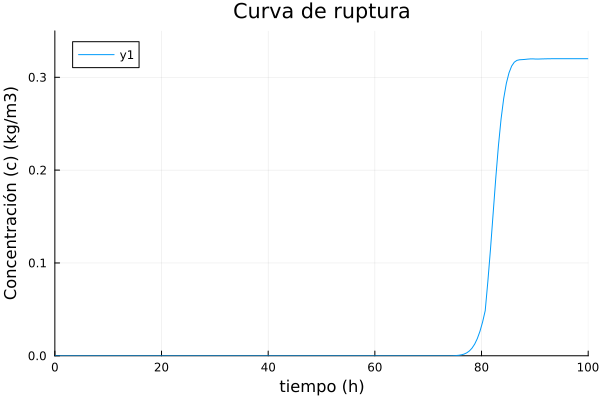

In [130]:
#Curva de ruptura
c_out = [c[i][end] for i in 1:length(c)]
n = length(c_out);
Δt = t_end/(n-1);
t_axis = [Δt*i/3600 for i in 0:n-1]; #en horas

plot(t_axis,c_out, xlimits=(0,t_end/3600), ylimits=(0,0.35),title = "Curva de ruptura",
xlabel = "tiempo (h)", ylabel = "Concentración (c) (kg/m3)")
#savefig("Curva_ruptura_c_2_fino.pdf")w

In [131]:
#Perfiles de Concentración a lo largo del lecho
# Buscar 11 índices equidistantes en t_axis (h)
ind = round.(Int, range(1, length(t_axis), length = 11)) 

plot()  # iniciar gráfico 

for i in ind
    a = round(t_axis[i]; digits = 2)
    plot!(z, c[i], label = "t = $a h")
end

xlabel!("Longitud del lecho (m)")
ylabel!("Concentración (kg/m^3)")
title!("Perfiles de concentración")
savefig("perfiles_concentracion_c_2_fino.pdf")

"c:\\Users\\jbega\\OneDrive\\Escritorio\\IPRE INVIERNO 2025\\perfiles_concentracion_c_2_fino.pdf"

In [132]:
# Crea DataFrame
df = DataFrame(c, :auto)

# Convertimos los nombres de las columnas a segundos
df = rename(df, string.(round.(t_axis*3600, digits = 2)))

# Exporta DataFrame como un CSV
CSV.write("c_fino.csv", df)

"c_fino.csv"

**Referencias**

[1] W. L. McCabe, J. C. Smith, and P. Harriott, Unit Operations of Chemical Engineering, 7th ed., Int. student ed. Boston, MA, USA: McGraw-Hill Higher Education, 2005.

[2] H. Jorquera González and C. Gelmi Weston, Métodos numéricos aplicados a la Ingeniería : Casos de estudio usando Matlab , First edition. in Colección Textos universitarios (Santiago, Chile). Santiago, Chile: Ediciones UC, 2014.

[3] Z. C. Atesci and H. Inan, “Removal of microfiber and surfactants from household laundry washing effluents by powdered activated carbon: kinetics and isotherm studies,” Water Science and Technology, vol. 88, no. 6, pp. 1578–1593, Sep. 2023, doi: 10.2166/wst.2023.281.

[4] A. Sharaf and Y. Liu, “Mechanisms and kinetics of greywater treatment using biologically active granular activated carbon”, Chemosphere, vol. 263, p. 128113, 2021, doi:https://doi.org/10.1016/j.chemosphere.2020.128113.